# MATH 405/607 

# Numerical Methods for Differential Equations

[[Instructor: Christoph Ortner]](http://www.math.ubc.ca/~ortner/)  [[course page]](https://github.com/cortner/math405_2022)

# Interpolation 


# Interpolation 

* polynomials 
* approximation by interpolation 
* splines

### Literature 

* [Driscoll, Fundamentals of Numerical Computations](https://fncbook.github.io/fnc/localapprox/overview.html)
* Süli and Mayers, An Introduction to Numerical Analysis, Ch 6-11 : range of elementary and advanced material
* Trefethen, Approximation Theory and Approximation Practise : more advanced material

In [1]:
include("math405.jl")

┌ Info: You are not running in the `math405` Jupyter Hub environment. 
│ I'm therefore activating the local environment.
│ Make sure you know what you are doing! If this is unintentional 
│ then get in touch with your instructor to get help.
└ @ Main /Users/ortner/gits/math405_2022/notes/math405.jl:7
  Activating project at `~/gits/math405_2022/notes`


### Approximation by "simple functions"

Virtually all of numerical analysis and scientific computing relies on our ability to approximate "complex" functions by "simple" functions. For example, it is easy to define functions $f$ through 

$$\begin{aligned}
    & f(x) = {\rm erf}(x) = \int_{0}^x \exp( - t^2) \, dt, \text{  or}   \\ 
    & x^2 f_{xx} + x f_x + (x^2 - \alpha^2) f = 0, 
\end{aligned}$$

but it is not so easy to evaluate them. This is particularly common when solving inhomogeneous and nonlinear differential equations. We often know that there is a unique solution specified by the DE, but we are unable to evaluate it because we cannot find a (or there is no) closed-form expression.

The idea is to *approximate* $f(x)$ by *simple functions*. (NB: in the ML literature the term "represent" is often more common.)

### Approximation by "simple functions"

What are simple functions? 

Functions we can evaluate on a computer:

*LAYER 1:* only allow +, -, *, $\div$
  - Polynomials: $p(x) = a_0 + a_1 x + \dots + a_N x^N$ 
  - Rationals: $r(x) = p(x) / q(x)$

*LAYER 2:* Exponentials and special functions
  - e.g., $\exp, \sin, \cos, \log, \arccos, \arcsin, \tan, \arctan$, bessel, $\Gamma$, $B$, erf, airy, $\zeta$, ... 
  - These are normally reduced to LAYER 1, usually rationals, and there are excellent software libraries to evaluate them. In Julia see e.g. `SpecialFunctions.jl`

A numerical analyst should use information about the problem at hand to decide which of these function classes are suitable. In this lecture, for simplicity and with an eye to quadrature and spectral methods later in the course, we will focus on polynomials.

## Polynomials 

**Definition:** a function $p : \mathbb{R} \to \mathbb{R}$ of the form 
$$ 
    p(x) = a_0 + a_1 x + \dots a_N x^N
$$
with $a_n \in \mathbb{R}$ and $a_N \neq 0$ is a polynomial of degree $N$. The $a_i$ are called the coefficients. 

(We can also consider complex polynomials but for this lecture we will focus on the real case.)

A polynomial given in the above format (there are many others!) is typically  evaluated using the Horner scheme: 

$$
    p(x) = a_0 + x(a_1 + x (a_2 + \dots + x (a_{N-1} + x a_N)
$$

In julia this is implemented as [`evalpoly`](https://github.com/JuliaLang/julia/blob/f130d9baa88e353601672c2627b275d02c1f308c/base/math.jl#L135)

In [2]:
# 1 + x + x^2 + ... + x^9 = (x^10 - 1)/(x-1)
x = 0.54321
@show evalpoly(x, ones(10))
@show (x^(10) - 1) / (x-1);

evalpoly(x, ones(10)) = 2.1842924327526276
(x ^ 10 - 1) / (x - 1) = 2.1842924327526276


**Weierstrass Approximation Theorem:** 
* Let $f \in C([a, b])$ then for all $\epsilon > 0$ there exists a polynomial $p$ such that $\| f - p \|_\infty \leq \epsilon$. 
* Or equivalently: the polynomials are dense in $C[a,b]$ for all $a < b \in \mathbb{R}$. 

**Proof:** Using Bernstein polynomials. See separate board/tablet lecture.

In particular this proves that smooth functions are dense in $C[a, b]$.

Weierstrass is a powerful abstract result. But we are in the business of concrete computations. How to *construct* good approximations? 

### Taylor Expansion 

$$
   f(x) \approx \sum_{n = 0}^N (x - x_0)^n \frac{f^{(n)}(x_0)}{n!}
$$

Why is this a bad idea? 

- radius of convergence 
- high derivatives could be difficult to obtain

#### The Witch of Agnesi 

[some historical context](https://mathworld.wolfram.com/WitchofAgnesi.html) - we will return to this example

$$
f(x) = \frac{1}{1 + \alpha^2 x^2}
$$ 
has singularities at $m = \pm i \alpha$. So the radius of convergence if we expand at $x_0 = 0$ will be just $1/\alpha$. 

In [3]:
α = 2    # agnesi function parameter 
N = 8     # polynomial degree 
f = x -> 1 / (1 + α^2 * x^2)

# this is a little piece of Julia trickery to get the higher derivatives 
# you don't necessarily need to understand this. This is very inefficient
# do not increase N!!! A better approach would be using   Symbolics.jl
using ForwardDiff 
df = Any[f,]
coeffs = [1.0,]
for n = 1:N 
    push!(df, x -> ForwardDiff.derivative(df[n], x))
    push!(coeffs, df[n+1](0.0))
end
coeffs

9-element Vector{Float64}:
      1.0
     -0.0
     -8.0
      0.0
    384.0
      0.0
 -46080.0
      0.0
      1.032192e7

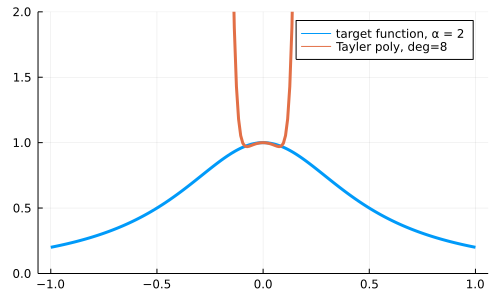

In [4]:
xp = range(-1, 1, length=200)
plot(xp, f.(xp), lw=3, size=(500, 300), label = "target function, α = $α", ylims = [0.0, 2.0])
plot!(xp, evalpoly.(xp, Ref(coeffs)), lw=3, label = "Tayler poly, deg=$N")

## Polynomial Interpolation 

We now know that polynomials are dense. Obvious questions that arise are how to construct good approximations in practise, e.g., given $f$ how can we construct the best approximation of degree $N$? This is difficult and we won't discuss it here.

A typical scenario is that one has function values $f(x_n)$ available at some points $x_n \in [a, b]$, $n = 0, \dots, N$. The idea then is to construct a polynomial $p$ matching $f$ at those points. This is called *polynomial interpolation* and the points $x_n$ are called the *interpolation nodes*.

Which degree should we use? 

A degree $N$ polynomial has $N+1$ parameters so most likely we can match exactly $N+1$ values.

In fact we have the following result: 

**Proposition:** For $N+1$ distinct points $x_0, \dots, x_N$ and values $f_0, \dots, f_N$ there exists a unique polynomial $p$ of degree $N$ such that $p(x_n) = f_n$ for $n = 0, \dots, N$. 

**Proof Existence:** constructive
 $$
     L_n(x) := \frac{\prod_{k \neq n} (x - x_k)}{\prod_{k \neq n} (x_n - x_k)}
 $$
 then $L_n(x_k) = \delta_{nk}$ and therefore 
 $$ 
     p(x) = \sum_{n = 0}^N f_n L_n(x)
 $$
 

 **Proof uniqueness:** WLOG $f_n = 0$. If $p$ has degree $N$ then 
 $$
     p(x) = a_N \prod_{n = 1}^N (x - x_n)
 $$
 But $p(x_0) = 0$ implies $a_N = 0$. 

### Interpolation - the canonical (but "wrong") way 

Solve the linear system for the coefficients $a_i$:
$$ 
    \sum_{n = 0}^N a_i x_i^n = f_i, \qquad i = 0, \dots, N
$$

Because there is a unique interpolant, and a polynomial is uniquely determined by its coefficients, it follows that there is a unique solution. The system matrix $V = ( x_i^n )_{i, n = 0}^N$ is called *Vandermonde matrix*.

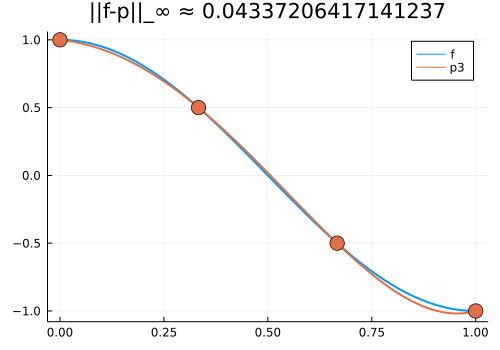

In [11]:
"compute the coefficients of the interpolating polynomial"
get_coeffs(X, F) =  [ x^n for x in X, n=0:length(X) ] \ F

f = x -> cos(pi*x)
N = 3   # try N = 5, 10, 20 
X = range(0, 1, length=N+1)
a = get_coeffs(X, f.(X))

xp = range(0, 1, length=300)
plot(xp, f.(xp), lw=2, label = "f", size=(500, 350))
plot!(xp, evalpoly.(xp, Ref(a)), lw=2, label = "p$(N)")
scatter!(X, f.(X), ms=8, c =  2, label = "")
title!("||f-p||_∞ ≈ $(norm(f.(xp)-evalpoly.(xp, Ref(a)), Inf))")

### Beware the Witch of Agnesi


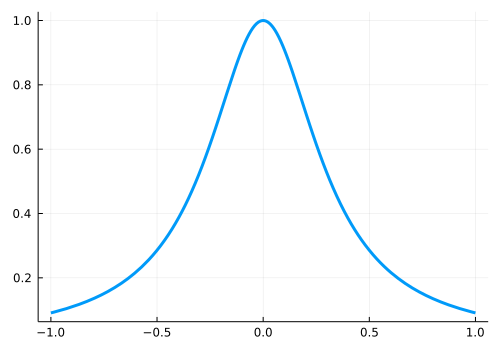

In [12]:
f = x -> 1 / (1 + 10 * x^2)
plt = plot(f, -1, 1, lw=3, label = "f", size=(500, 350), legend = nothing)

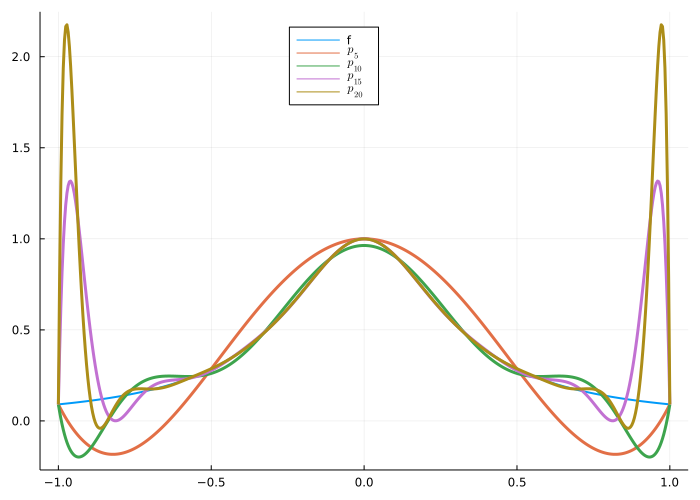

In [13]:
myevalpoly(xp::AbstractVector, f::Function, X) = evalpoly.(xp, Ref(get_coeffs(X, f.(X))))

f = x -> 1 / (1 + 10 * x^2)

xp = range(-1, 1, length=500)
plt = plot(xp, f.(xp), lw=2, label = "f", size=(700, 500), legend = :top)
for N in [5, 10, 15, 20]
    plot!(xp, myevalpoly(xp, f, range(-1,1,length=N)), lw=3, label = latexstring("p_{$(N)}"))
end
plt

### Chebyshev Interpolation 

It is initially counter-intuitive but it turns out that equispaced interpolation is a poor choice for global polynomial approximation. A much better choice are the Chebyshev nodes
$$ 
   x_n := \cos( \pi n / N )
$$
where - for convenience - we are now approximating functions on $f \in C([-1,1])$.

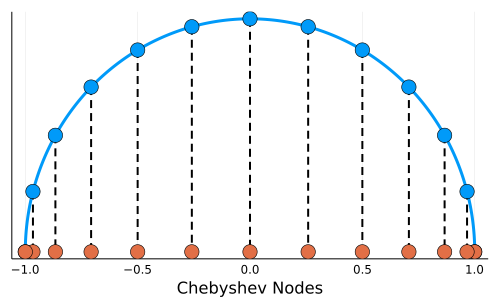

In [14]:
MATH405.chebyshev_projection(12)

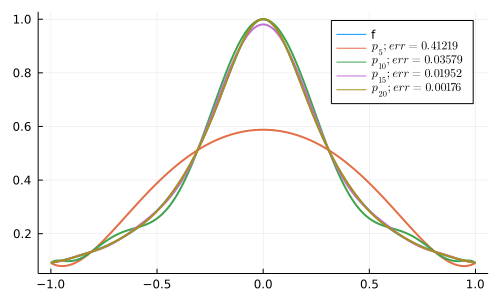

In [15]:
chebnodes(N) = cos.(range(0, pi, length=N+1))
f = x -> 1 / (1 + 10 * x^2)

xp = range(-1, 1, length=500)
plt = plot(xp, f.(xp), lw=2, label = "f", size=(500, 300), legend = :topright)
for N in [5, 10, 15, 20]
    pN = myevalpoly(xp, f, chebnodes(N)); err = norm(f.(xp)-pN, Inf)
    plot!(xp, pN, lw=2, label = latexstring("p_{$(N)}; {\\rm err} = $(round(err, digits=5))"))
end
plt

Deeply understanding this effect goes beyond this introductory lecture, but I hope we can return to it at the end of this course. For now we take these examples as a warning that *global* polynomial interpolation is fraught with traps but they are well understood and can be avoided. A very nice book to study this is [Nick Trefethen's Approximation Theory and Approximation Practise](https://people.maths.ox.ac.uk/trefethen/ATAP/ATAPfirst6chapters.pdf)

And we will see a partial explanation in the following interpolation error analysis.

### Interpolation Error Analysis 

Interpolation of smooth functions generally leads to small errors. "The smoother the function is the faster the rate of convergence."

**Theorem:** Let $f \in C^{N+1}([x_0, x_N])$ and $p_N(x)$ the interpolant on the nodes $x_0 < \dots < x_N$. Then, for every $x \in [x_0, x_N]$ there exists $\xi = \xi(x)$ s.t. 
$$
    f(x) - p_N(x) 
    = 
    (x - x_0) (x - x_1) \cdots (x - x_N) \frac{f^{(N+1)}(\xi)}{(N+1)!}.
$$

**Corollary:** If the $a \leq x_0 < \dots < x_N \leq b$ then 
$$ 
    \| f - p_N\|_{L^\infty(a,b))}
    \leq 
    \frac{(b - a)^{N+1} \| f^{(N+1)} \|_{L^\infty(a,b)}}{(N+1)!}.
$$

But a better estimate would be 
$$ 
    \| f - p_N\|_{L^\infty(a,b))}
    \leq 
    \|\ell\|_{L^\infty(a,b)} \frac{\| f^{(N+1)} \|_{L^\infty(a,b)}}{(N+1)!}.
$$
where $\ell(x) = \prod_{n=0}^N (x-x_n)$.  This is called the *node polynomial*.

For example, if the nodes are symmetric about the mid-point of the interval then one can prove  (cf. exercises)
$$
    \| \ell \|_{L^\infty} \leq \Big(\frac{b - a}{2}\Big)^{N+1}
$$

We should now analyze $\|\ell\|_\infty$ more carefully, but instead let's explore it numerically:

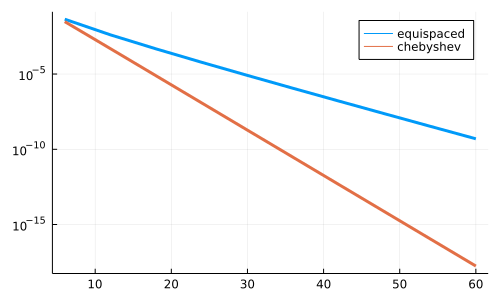

In [16]:
eval_L(x, X) = prod( (x - xn) for xn in X )
norm_L(X) = maximum( abs( eval_L(x, X) ) for x in range(-1, 1, length=10_000) )
NN = 6:6:60
nrm_equi = [ norm_L(range(-1, 1, length=N+1)) for N in NN ]
nrm_cheb = [ norm_L(chebnodes(N)) for N in NN ]
plot(NN, nrm_equi, lw=3, label = "equispaced", size = (500, 300))
plot!(NN, nrm_cheb, lw=3, label = "chebyshev", yscale = :log10)

The following numerical results don't quite follow from what we covered above, but are closely related. More 
material to be covered when we do spectral methods at the end.

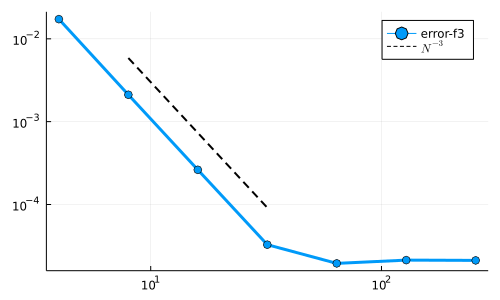

In [19]:
# Convergence for a C^{2,1} function: 
#  (basically three times differentiable but with a weaker notion of 3rd derivative!)
f3 = x -> abs(x)^3
xe = range(-1,1,length=10_000)
NN3 = (2).^(2:8)
err3 = [ norm( myevalpoly(xe, f3, chebnodes(N)) - f3.(xe), Inf ) for N in NN3 ]
plot(NN3, err3, lw=3, label = "error-f3", m=:o, ms=4, yscale = :log10, xscale = :log10, size = (500, 300))
plot!(NN3[2:4], 3*NN3[2:4].^(-3), lw=2, ls=:dash, c=:black, label = L"N^{-3}")

Why can't we go beyond $10^{-5}$ accuracy? That's the numerical instability in our interpolation scheme!! (cf condition number of Vandermonde Matrix!)

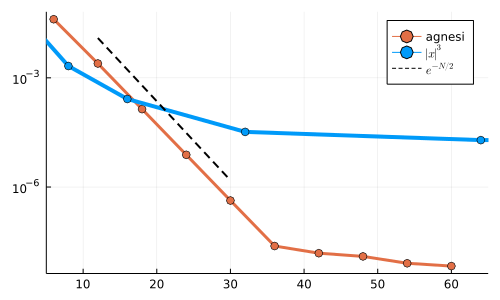

In [20]:
# Convergence for an analytic function:
fa = x ->  1 / (1+4*x^2)
NNa = 6:6:60
erra = [ norm( myevalpoly(xe, fa, chebnodes(N)) - fa.(xe), Inf ) for N in NNa ]
plot(NNa, erra, lw=3, label = "agnesi", m=:o, ms=4, c=2, yscale = :log10, size = (500, 300))
plot!(NN3, err3, lw=4, label =  L"|x|^3", m=:o, ms=4, c=1, xlims = [5, 65])
plot!(NNa[2:5], 5*exp.(-1/2*NNa[2:5]), lw=2, ls=:dash, c=:black, label = L"e^{- N / 2}")

Note again the numerical instability. There are ways to deal with this, e.g., barycentric interpolation (see assignment A2); lsq, irlsq, ... 

## Splines 

Motivation:
$$ 
    \| f - p_N\|_{L^\infty(a,b))}
    \leq 
    \Big(\frac{b - a}{2}\Big)^{N+1} \frac{\| f^{(N+1)} \|_{L^\infty(a,b)}}{(N+1)!}.
$$

Apart from the (extremely complex) choice of nodes we have two parameters to play with: the degree $N$ and the interval-length $(b-a)$. We have already seen that increasing $N$ must be done carefully. By contrast, making $b-a$ smaller appears to be very robust from the above formula! 

But the domain is given to us, we do not get to choose it. Instead what we can do is sub-divide it and perform independent approximations on each subdomain. This leads to so-called *spline approximations*.

### Piecewise linear splines 

Subdivide $[a, b]$ into $a = x_0 < x_1 < \dots, < x_M = b$ and on $(x_{m-1}, x_m)$ approximate
$$
    f(x) \approx s_1(x) := f(x_{m-1}) \frac{x_m - x}{x_m - x_{m-1}} 
                + f(x_m) \frac{x - x_{m-1}}{x_m - x_{m-1}}
$$

In [ ]:
f = x -> (1 + 10 * x^2)^(-1)
X = range(-1, 1, length = 9)
plot(f, -1, 1, lw=3, label = L"f", size = (600, 300))
plot!(X, f.(X), lw=3, marker = :o, ms = 6, label = L"s_1", c=3)

#### Piecewise quadratic splines 

On each subinterval $[x_{m-1}, x_m]$ let $s_2(x) \in \mathcal{P}_2$ be the nodal interpolant at the nodes 
$$
x_{m-1}, \qquad  \frac{1}{2}(x_{m-1}+x_m), \qquad x_m
$$ 
i.e. at end-points and mid-point. This is more tedious to write down explicitly but can be done; just use the lagrange basis functions $L_0, L_1, L_2$ on each sub-interval.

In [ ]:
f = x -> 1/(1+10*x^2)
p2(x, f, x0, x1, x2) = ( f(x0) * (x-x1)*(x-x2)/(x0-x1)/(x0-x2)
                        +f(x1) * (x-x0)*(x-x2)/(x1-x0)/(x1-x2)
                        +f(x2) * (x-x0)*(x-x1)/(x2-x0)/(x2-x1) )
X = range(-1, 1, length=9)
Xm = (X[2:end] + X[1:end-1])/2
plt = plot(f, -1, 1, lw=3, label = L"f", size = (600, 300))
plot!(X, f.(X), lw=3, marker = :o, ms = 6, label = L"s_1", c=3)
for m = 2:length(X)
    xp = range(X[m-1], X[m], length=20)
    plot!(xp, p2.(xp, f, X[m-1], Xm[m-1], X[m]), lw=3, label = "", c=2)
end
plot!(Xm, f.(Xm), m=:square, ms=6, c=2, lw=0, label = L"s_2")
plt

**Theorem:** Let $x_m$ be equispaced with spacing $h = x_m - x_{m-1}$ and let $s_N$ be the piecewise nodal interpolant of $f$ with equispaced nodes on each sub-interval, then 
$$ 
    \|f - s_N\|_\infty \leq \frac{(h/2)^{N+1}}{(N+1)!} \| f^{(N+1)} \|_\infty
$$

**Note:** For fixed $N$ but $M \to \infty$ ($h \to 0$) this is called *algebraic* convergence and should be contrasted with *exponential* convergence. More on this at the end of the course when we return to global polynomial approximation and spectral methods.

We won't explore this further, but use it for motivating the next section on quadrature. For further reading see B-splines, and [`Interpolations.jl`](https://github.com/JuliaMath/Interpolations.jl), [`Dierckx.jl`](https://github.com/kbarbary/Dierckx.jl)

## Summary Approximation and Interpolation

* approximation of general functions by "simple functions"
* polynomial approximation, error vs smoothness!
* interpolation is a simple way for constructive approximation
* equispaced interpolation is *in general* unstable
* Chebyshev interpolation is not optimal but simple and close to optimal
* alternatively, use splines, i.e. control error through grid size / mesh size
* more complex: balance degree and mesh size, i.e. $hp$ approximation

### Further reading

* We may return to polynomial approximation in the last part of the course, e.g. how good is the best-approximation? How close is the Chebyshev interpolant to the best approximation? 
* There are many variants of spline interpolation, a popular class are **B-splines**
* Finite elements are the generalisation of splines to dimension > 1.
* polynomial regression